In [2]:
%pip install pandas numpy matplotlib seaborn scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

In [4]:
df = pd.read_csv('profanity_en.csv')

In [5]:
print(df.head())


        text canonical_form_1 canonical_form_2 canonical_form_3  \
0         69               69              NaN              NaN   
1        @55              ass              NaN              NaN   
2   @ssfcker             fuck              ass              NaN   
3  @ssfucker             fuck              ass              NaN   
4  @ssfvcker             fuck              ass              NaN   

                     category_1                   category_2 category_3  \
0  sexual anatomy / sexual acts                          NaN        NaN   
1  sexual anatomy / sexual acts                          NaN        NaN   
2  sexual anatomy / sexual acts  sexual orientation / gender        NaN   
3  sexual anatomy / sexual acts  sexual orientation / gender        NaN   
4  sexual anatomy / sexual acts  sexual orientation / gender        NaN   

   severity_rating severity_description  
0              1.0                 Mild  
1              1.0                 Mild  
2              2.8  

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  1598 non-null   object 
 1   canonical_form_1      1598 non-null   object 
 2   canonical_form_2      210 non-null    object 
 3   canonical_form_3      6 non-null      object 
 4   category_1            1598 non-null   object 
 5   category_2            486 non-null    object 
 6   category_3            21 non-null     object 
 7   severity_rating       1598 non-null   float64
 8   severity_description  1598 non-null   object 
dtypes: float64(1), object(8)
memory usage: 112.5+ KB
None


In [7]:
print(df.describe(include='all'))

              text canonical_form_1 canonical_form_2 canonical_form_3  \
count         1598             1598              210                6   
unique        1598              244               33                5   
top     zipperhead             fuck              ass              ass   
freq             1              307               46                2   
mean           NaN              NaN              NaN              NaN   
std            NaN              NaN              NaN              NaN   
min            NaN              NaN              NaN              NaN   
25%            NaN              NaN              NaN              NaN   
50%            NaN              NaN              NaN              NaN   
75%            NaN              NaN              NaN              NaN   
max            NaN              NaN              NaN              NaN   

                          category_1              category_2  \
count                           1598                     48

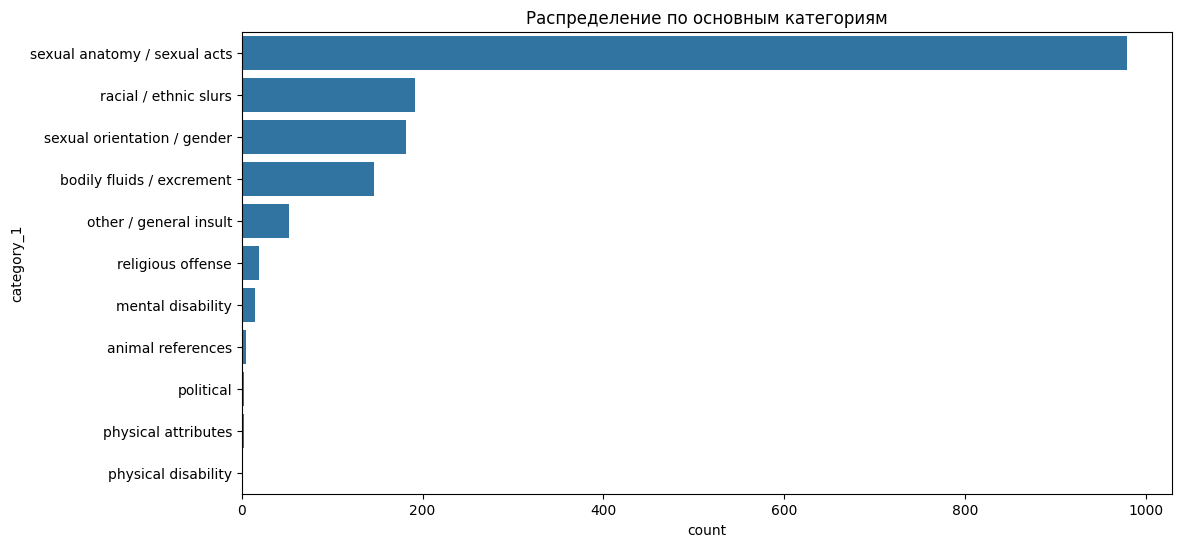

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(y='category_1', data=df, order=df['category_1'].value_counts().index)
plt.title('Распределение по основным категориям')
plt.show()

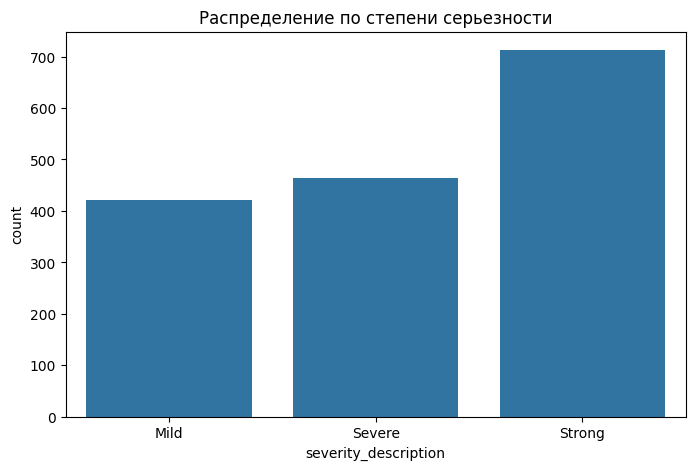

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='severity_description', data=df)
plt.title('Распределение по степени серьезности')
plt.show()

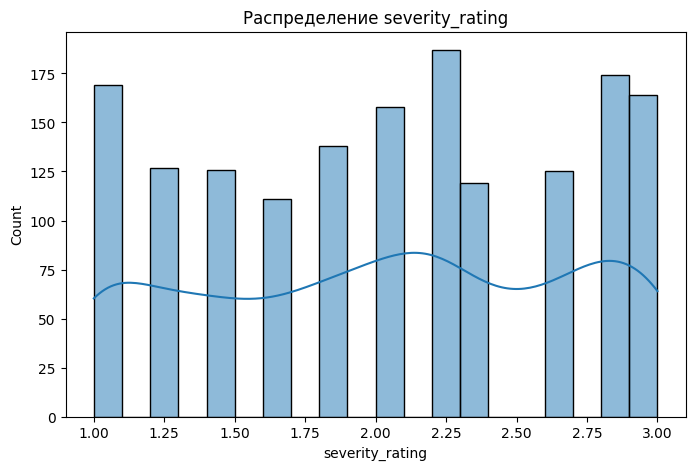

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['severity_rating'], bins=20, kde=True)
plt.title('Распределение severity_rating')
plt.show()

In [11]:
print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
text                       0
canonical_form_1           0
canonical_form_2        1388
canonical_form_3        1592
category_1                 0
category_2              1112
category_3              1577
severity_rating            0
severity_description       0
dtype: int64


In [12]:
# Выводы:
#Основные категории ненормативной лексики: sexual orientation/gender, sexual anatomy/acts, bodily fluids
#Большинство слов имеют уровень серьезности Strong
#Есть пропущенные значения в canonical_form_2, canonical_form_3 и дополнительных категориях
#Текст является основным признаком для классификации

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anmrt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anmrt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anmrt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [15]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [16]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    
    #Заполнение пропущенных значений
    df['category_1'] = df['category_1'].fillna('other')
    df['severity_description'] = df['severity_description'].fillna('Mild')
    
    #Удаление редких категорий (менее 5 примеров)
    category_counts = df['category_1'].value_counts()
    rare_categories = category_counts[category_counts < 5].index
    df = df[~df['category_1'].isin(rare_categories)]
    
    df['processed_text'] = df['text'].apply(preprocess_text)
    
    cleaned_filepath = filepath.replace('.csv', '_cleaned.csv')
    df.to_csv(cleaned_filepath, index=False)
    
    return df, cleaned_filepath

In [17]:
filepath = 'profanity_en.csv'
df, cleaned_filepath = load_and_preprocess_data(filepath)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category_1'])

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
#Log regression
lr_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('lr', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        C=1.0,
        random_state=42
    ))
])

In [19]:
#Random forest
rf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=None,
        random_state=42
    ))
])

In [20]:
#Soft voting ensamble
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_pipeline),
        ('rf', rf_pipeline)
    ],
    voting='soft'
)

In [21]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    print(f"\nEvaluation for {model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    
    #Уникальные классы в y_test и y_pred
    present_labels = np.unique(np.concatenate([y_test, y_pred]))
    target_names = label_encoder.inverse_transform(present_labels)
    
    print(classification_report(
        y_test, 
        y_pred, 
        labels=present_labels,
        target_names=target_names
    ))
    
    return model

In [22]:
lr_model = train_and_evaluate(lr_pipeline, X_train, y_train, X_test, y_test, "Logistic Regression")
rf_model = train_and_evaluate(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest")
ensemble_model = train_and_evaluate(ensemble, X_train, y_train, X_test, y_test, "Ensemble Model")


Training Logistic Regression...

Evaluation for Logistic Regression:
Accuracy: 0.664576802507837

Classification Report:
                              precision    recall  f1-score   support

           animal references       0.00      0.00      0.00         1
   bodily fluids / excrement       0.43      0.10      0.17        29
           mental disability       0.00      0.00      0.00         3
      other / general insult       0.25      0.20      0.22        10
       racial / ethnic slurs       1.00      0.21      0.34        39
           religious offense       1.00      1.00      1.00         4
sexual anatomy / sexual acts       0.67      0.95      0.78       197
 sexual orientation / gender       0.70      0.19      0.30        36

                    accuracy                           0.66       319
                   macro avg       0.51      0.33      0.35       319
                weighted avg       0.67      0.66      0.60       319


Training Random Forest...


c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


Evaluation for Random Forest:
Accuracy: 0.670846394984326

Classification Report:
                              precision    recall  f1-score   support

           animal references       0.00      0.00      0.00         1
   bodily fluids / excrement       0.60      0.10      0.18        29
           mental disability       0.00      0.00      0.00         3
      other / general insult       1.00      0.20      0.33        10
       racial / ethnic slurs       1.00      0.15      0.27        39
           religious offense       1.00      0.75      0.86         4
sexual anatomy / sexual acts       0.66      0.98      0.79       197
 sexual orientation / gender       0.75      0.17      0.27        36

                    accuracy                           0.67       319
                   macro avg       0.63      0.29      0.34       319
                weighted avg       0.71      0.67      0.59       319


Training Ensemble Model...


c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


Evaluation for Ensemble Model:
Accuracy: 0.664576802507837

Classification Report:
                              precision    recall  f1-score   support

           animal references       0.00      0.00      0.00         1
   bodily fluids / excrement       0.60      0.10      0.18        29
           mental disability       0.00      0.00      0.00         3
      other / general insult       0.40      0.20      0.27        10
       racial / ethnic slurs       1.00      0.15      0.27        39
           religious offense       1.00      1.00      1.00         4
sexual anatomy / sexual acts       0.66      0.97      0.78       197
 sexual orientation / gender       0.75      0.17      0.27        36

                    accuracy                           0.66       319
                   macro avg       0.55      0.32      0.35       319
                weighted avg       0.69      0.66      0.58       319



c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anmrt\Desktop\practice_6sem\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

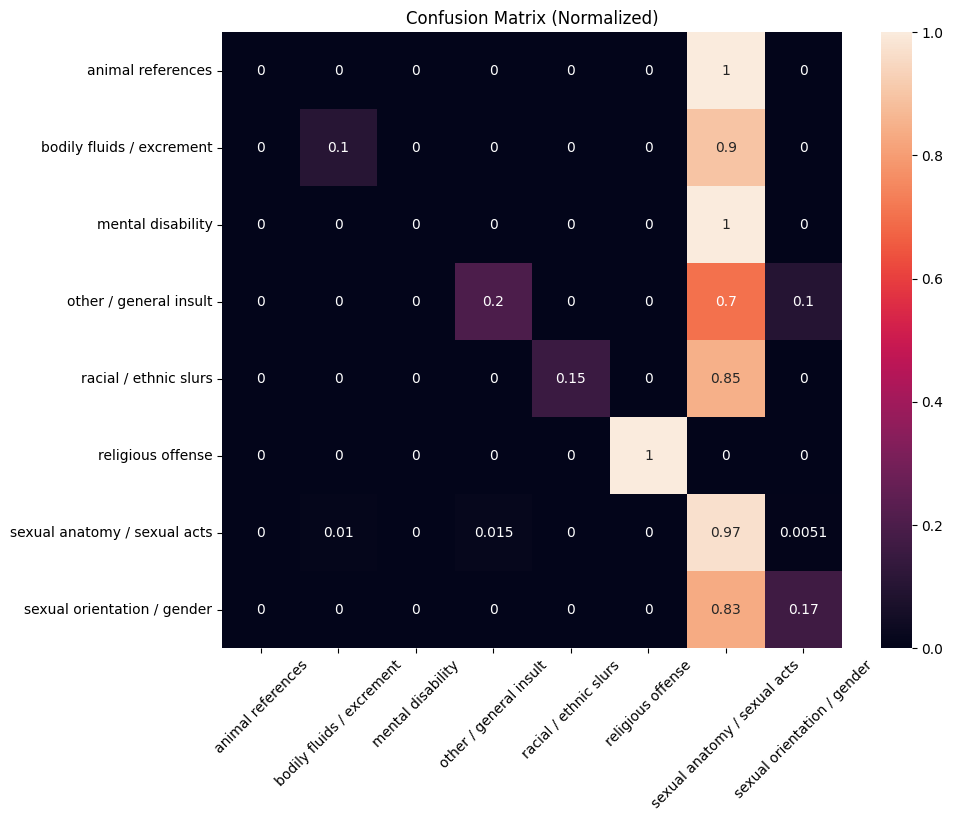

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = ensemble_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Normalized)')
plt.xticks(rotation=45)
plt.show()

In [23]:
def predict_profanity(text, model, label_encoder):
    processed_text = preprocess_text(text)
    prediction = model.predict([processed_text])
    probability = np.max(model.predict_proba([processed_text]))
    category = label_encoder.inverse_transform(prediction)[0]
    return category, probability

# Тестирование на примерах
test_phrases = [
    "This is a normal sentence",
    "stupid idiot",
    "fucking hell",
    "you bitch",
    "that's amazing"
]

print("\nTesting model on sample phrases:")
for phrase in test_phrases:
    category, prob = predict_profanity(phrase, ensemble_model, label_encoder)
    print(f"Phrase: '{phrase}'")
    print(f"Predicted category: {category} (probability: {prob:.2f})")
    print("-" * 50)


Testing model on sample phrases:
Phrase: 'This is a normal sentence'
Predicted category: sexual anatomy / sexual acts (probability: 0.61)
--------------------------------------------------
Phrase: 'stupid idiot'
Predicted category: sexual anatomy / sexual acts (probability: 0.56)
--------------------------------------------------
Phrase: 'fucking hell'
Predicted category: sexual anatomy / sexual acts (probability: 0.59)
--------------------------------------------------
Phrase: 'you bitch'
Predicted category: sexual orientation / gender (probability: 0.79)
--------------------------------------------------
Phrase: 'that's amazing'
Predicted category: sexual anatomy / sexual acts (probability: 0.61)
--------------------------------------------------
